In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor

df =pd.read_csv("../Data/clean_data/encoded_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32416 entries, 0 to 32415
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   person_age                     32416 non-null  int64  
 1   person_income                  32416 non-null  int64  
 2   person_employment_length       32416 non-null  float64
 3   loan_grade                     32416 non-null  object 
 4   loan_amount                    32416 non-null  int64  
 5   loan_interest_rate             32416 non-null  float64
 6   loan_status                    32416 non-null  int64  
 7   loan_to_income_ratio           32416 non-null  float64
 8   cb_credit_history_length       32416 non-null  int64  
 9   person_income_log              32416 non-null  float64
 10  loan_amount_log                32416 non-null  float64
 11  loan_grade_numeric             32416 non-null  int64  
 12  credit_history_bins            32416 non-null 

In [2]:
# Remove one from each highly correlated pair
# Why: loan_amount_log and person_income_log preserve relationships while handling skew
# Low-variance one-hot features add noise without predictive power
df.drop(columns=['loan_amount', 'person_income'], inplace=True)  # Keeping log versions

# Drop low-variance one-hot columns (threshold <5%)
low_variance_cols = ['person_home_ownership_other', 'loan_purpose_venture']
df.drop(columns=low_variance_cols, inplace=True)

# Verify
print(f"Columns remaining: {list(df.columns)}")

Columns remaining: ['person_age', 'person_employment_length', 'loan_grade', 'loan_interest_rate', 'loan_status', 'loan_to_income_ratio', 'cb_credit_history_length', 'person_income_log', 'loan_amount_log', 'loan_grade_numeric', 'credit_history_bins', 'person_home_ownership_own', 'person_home_ownership_rent', 'loan_purpose_education', 'loan_purpose_home-improvement', 'loan_purpose_medical', 'loan_purpose_personal', 'cb_person_default_on_file_Y']


In [3]:
### Why These Features:

### risk_tier: Captures how interest rates compound with loan grade risk

### income_adequacy: More sensitive to low-income borrowers

### employment_stability: Non-linear relationship with default risk

### debt_burden: Penalizes large loans more severely
# 1. Risk Tier (combines grade and interest rate)
df['risk_tier'] = df['loan_grade_numeric'] * df['loan_interest_rate']

# 2. Income Adequacy Ratio (more sensitive than standard ratio)
df['income_adequacy'] = df['person_income_log'] / (df['loan_amount_log'] + 1) 

# 3. Employment Stability Bins
df['employment_stability'] = pd.cut(
    df['person_employment_length'],
    bins=[0, 2, 5, 10, np.inf],
    labels=['new', 'mid', 'experienced', 'veteran']
)

# 4. Debt Burden Interaction
df['debt_burden'] = np.sqrt(df['loan_amount_log']) * df['loan_to_income_ratio']

# Drop original columns we replaced
df.drop(columns=['loan_grade_numeric', 'person_employment_length'], inplace=True)

In [4]:
# One-hot encode the new stability bins
df = pd.get_dummies(df, columns=['employment_stability'], prefix='emp')

# Ordinal encode credit_history_bins (assuming ordered categories)
bin_order = ['<1y', '1-3y', '3-5y', '5-10y', '10+']
df['credit_history_ordinal'] = df['credit_history_bins'].map(
    {bin: i for i, bin in enumerate(bin_order)}
)
df.drop(columns=['credit_history_bins'], inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32416 entries, 0 to 32415
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   person_age                     32416 non-null  int64  
 1   loan_grade                     32416 non-null  object 
 2   loan_interest_rate             32416 non-null  float64
 3   loan_status                    32416 non-null  int64  
 4   loan_to_income_ratio           32416 non-null  float64
 5   cb_credit_history_length       32416 non-null  int64  
 6   person_income_log              32416 non-null  float64
 7   loan_amount_log                32416 non-null  float64
 8   person_home_ownership_own      32416 non-null  int64  
 9   person_home_ownership_rent     32416 non-null  int64  
 10  loan_purpose_education         32416 non-null  int64  
 11  loan_purpose_home-improvement  32416 non-null  int64  
 12  loan_purpose_medical           32416 non-null 

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Stratified split preserves class ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Default rate - Train: {y_train.mean():.2%}, Test: {y_test.mean():.2%}")

Train shape: (25932, 22), Test shape: (6484, 22)
Default rate - Train: 21.87%, Test: 21.87%


In [7]:
## Step 5: Manual Oversampling
def oversample(X, y, target_minority_pct=0.5):
    """
    target_minority_pct: Desired minority class percentage (e.g., 0.5 = 50%)
    """
    n_majority = sum(y == 0)
    n_minority = sum(y == 1)
    target_minority = int(n_majority * target_minority_pct / (1 - target_minority_pct))
    needed = target_minority - n_minority
    
    if needed <= 0:
        print("Already balanced or minority class exceeds target percentage.")
        return X, y
    
    X_minority = X[y == 1]
    X_extra = X_minority.sample(needed, replace=True, random_state=42)
    y_extra = pd.Series(1, index=X_extra.index)
    
    return pd.concat([X, X_extra]), pd.concat([y, y_extra])

# Apply with 50% minority class
X_train_res, y_train_res = oversample(X_train, y_train, target_minority_pct=0.5)
print(f"New class balance: {y_train_res.value_counts(normalize=True)}")


New class balance: 0    0.5
1    0.5
Name: proportion, dtype: float64


In [8]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

# --- After oversampling ---

# Encode loan_grade column (important!)
grade_order = [['A', 'B', 'C', 'D', 'E_or_lower']]
encoder = OrdinalEncoder(categories=grade_order)

X_train_res['loan_grade'] = encoder.fit_transform(X_train_res[['loan_grade']])
X_test['loan_grade'] = encoder.transform(X_test[['loan_grade']])

# Now scale numeric features
num_cols = X_train_res.select_dtypes(include=['float64', 'int64']).columns

binary_cols = [col for col in num_cols if X_train_res[col].nunique() == 2]
num_cols = [col for col in num_cols if col not in binary_cols]
num_cols = [col for col in num_cols if X_train_res[col].nunique(dropna=True) > 1]

scaler = StandardScaler()
X_train_res[num_cols] = scaler.fit_transform(X_train_res[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

model = RandomForestClassifier(
    class_weight=None,  # No need for class_weight because of oversampling
    n_estimators=300,
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42
)

model.fit(X_train_res, y_train_res)

y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]

y_train_res_pred = model.predict(X_train_res)
y_train_res_proba = model.predict_proba(X_train_res)[:, 1]

print("Train Classification Report:\n", classification_report(y_train_res, y_train_res_pred))
print("Train ROC AUC:", roc_auc_score(y_train_res, y_train_res_proba))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_test_proba))


Train Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     20261
           1       1.00      1.00      1.00     20261

    accuracy                           1.00     40522
   macro avg       1.00      1.00      1.00     40522
weighted avg       1.00      1.00      1.00     40522

Train ROC AUC: 1.0

Test Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      5066
           1       0.88      0.74      0.80      1418

    accuracy                           0.92      6484
   macro avg       0.90      0.85      0.88      6484
weighted avg       0.92      0.92      0.92      6484

Test ROC AUC: 0.926645570430821


In [10]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Initialize results dictionary (if not already initialized)
results = {}

# Define LightGBM model
model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    class_weight='balanced',  # optional with manual oversampling
    random_state=42
)

# Train on manually resampled training data
model.fit(X_train_res, y_train_res)

# Predict on original test set
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]

# Predict on resampled training data
y_train_res_pred = model.predict(X_train_res)
y_train_res_proba = model.predict_proba(X_train_res)[:, 1]

# Store evaluation results
results["LightGBM"] = {
    "test_report": classification_report(y_test, y_test_pred),
    "test_roc_auc": roc_auc_score(y_test, y_test_proba),
    "train_resampled_report": classification_report(y_train_res, y_train_res_pred),
    "train_resampled_roc_auc": roc_auc_score(y_train_res, y_train_res_proba)
}

# Print the results
print("\nLightGBM Model Performance (After Manual Oversampling):")
print("TRAIN SET (Resampled):")
print(results["LightGBM"]["train_resampled_report"])
print(f"ROC-AUC: {results['LightGBM']['train_resampled_roc_auc']:.4f}")
print("\nTEST SET (Original):")
print(results["LightGBM"]["test_report"])
print(f"ROC-AUC: {results['LightGBM']['test_roc_auc']:.4f}")
print("-" * 50)


[LightGBM] [Info] Number of positive: 20261, number of negative: 20261
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1637
[LightGBM] [Info] Number of data points in the train set: 40522, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

LightGBM Model Performance (After Manual Oversampling):
TRAIN SET (Resampled):
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     20261
           1       0.97      0.93      0.95     20261

    accuracy                           0.95     40522
   macro avg       0.95      0.95      0.95     40522
weighted avg       0.95      0.95      0.95     40522

ROC-AUC: 0.9925

TEST SET (Original):
              precision    recall  f1-score   suppor

In [18]:
from sklearn.metrics import precision_recall_curve, f1_score

# Get predicted probabilities for the positive class (1)
y_scores = model.predict_proba(X_test)[:, 1]

# Calculate precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calculate F1 scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # avoid div by zero

# Find threshold with max F1 score
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best threshold based on F1 score: {best_threshold:.4f}")
print(f"Best F1 score at this threshold: {best_f1:.4f}")

# Predict with the best threshold
y_pred_best_thresh = (y_scores >= best_threshold).astype(int)

# Show classification report with best threshold
print("\nClassification report with best threshold:")
print(classification_report(y_test, y_pred_best_thresh))


Best threshold based on F1 score: 0.8311
Best F1 score at this threshold: 0.8153

Classification report with best threshold:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      5066
           1       0.92      0.73      0.82      1418

    accuracy                           0.93      6484
   macro avg       0.92      0.86      0.89      6484
weighted avg       0.93      0.93      0.92      6484



In [13]:
from sklearn.metrics import precision_recall_curve

def find_threshold_for_min_recall(y_true, y_scores, target_recall=0.8):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    # recall and precision length = len(thresholds) + 1
    # find indices where recall >= target_recall
    valid_indices = [i for i, r in enumerate(recall[:-1]) if r >= target_recall]
    if not valid_indices:
        print("Warning: Cannot achieve target recall")
        return 0.5  # fallback
    
    # Choose threshold corresponding to the highest threshold among those indices
    best_idx = valid_indices[-1]  # last index where recall >= target_recall
    return thresholds[best_idx]

threshold_recall = find_threshold_for_min_recall(y_test, y_test_proba, 0.8)
print(f"Threshold for recall >= 0.8: {threshold_recall:.4f}")

y_pred_recall = (y_test_proba >= threshold_recall).astype(int)
print(classification_report(y_test, y_pred_recall))



Threshold for recall >= 0.8: 0.4691
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      5066
           1       0.81      0.80      0.81      1418

    accuracy                           0.92      6484
   macro avg       0.88      0.87      0.88      6484
weighted avg       0.92      0.92      0.92      6484



In [14]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score

# List of important features to keep (exact names as in your data)
important_features = [
    'person_income_log',
    'loan_interest_rate',
    'income_adequacy',
    'person_age',
    'loan_amount_log',
    'risk_tier',
    'debt_burden'
]

# Select only important features from training and test sets
X_train_res_imp = X_train_res[important_features]
X_test_imp = X_test[important_features]

# Initialize results dictionary (if not already initialized)
results = {}

# Define LightGBM model
model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    class_weight='balanced',  # optional if you used manual oversampling
    random_state=42
)

# Train on manually resampled training data (with important features only)
model.fit(X_train_res_imp, y_train_res)

# Predict on original test set (important features only)
y_test_pred = model.predict(X_test_imp)
y_test_proba = model.predict_proba(X_test_imp)[:, 1]

# Predict on resampled training data (important features only)
y_train_res_pred = model.predict(X_train_res_imp)
y_train_res_proba = model.predict_proba(X_train_res_imp)[:, 1]

# Store evaluation results
results["LightGBM"] = {
    "test_report": classification_report(y_test, y_test_pred),
    "test_roc_auc": roc_auc_score(y_test, y_test_proba),
    "train_resampled_report": classification_report(y_train_res, y_train_res_pred),
    "train_resampled_roc_auc": roc_auc_score(y_train_res, y_train_res_proba)
}

# Print the results
print("\nLightGBM Model Performance (After Manual Oversampling) - Important Features Only:")
print("TRAIN SET (Resampled):")
print(results["LightGBM"]["train_resampled_report"])
print(f"ROC-AUC: {results['LightGBM']['train_resampled_roc_auc']:.4f}")
print("\nTEST SET (Original):")
print(results["LightGBM"]["test_report"])
print(f"ROC-AUC: {results['LightGBM']['test_roc_auc']:.4f}")
print("-" * 50)


[LightGBM] [Info] Number of positive: 20261, number of negative: 20261
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1542
[LightGBM] [Info] Number of data points in the train set: 40522, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

LightGBM Model Performance (After Manual Oversampling) - Important Features Only:
TRAIN SET (Resampled):
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     20261
           1       0.90      0.90      0.90     20261

    accuracy                           0.90     40522
   macro avg       0.90      0.90      0.90     40522
weighted avg       0.90      0.90      0.90     40522

ROC-AUC: 0.9683

TEST SET (Original):
              precision    recall  f1-score   support

           0       0.94      0.88   

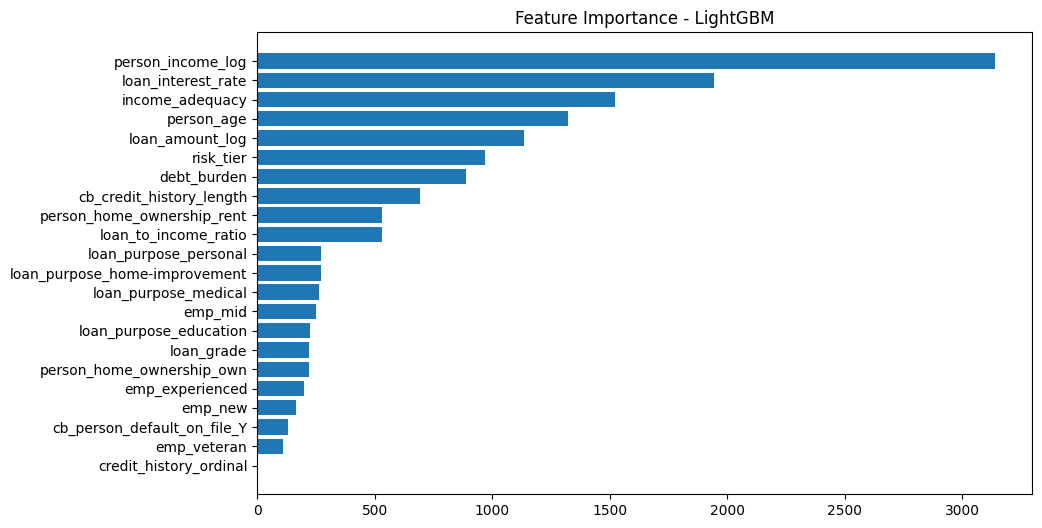

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# After fitting your LGBM model:
lgbm_importances = model.feature_importances_

# Create a DataFrame for better visualization
feat_imp_lgbm = pd.DataFrame({
    'feature': model.feature_name_,  # LightGBM's built-in feature names
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
# Plot
plt.figure(figsize=(10,6))
plt.barh(feat_imp_lgbm['feature'], feat_imp_lgbm['importance'])
plt.gca().invert_yaxis()
plt.title('Feature Importance - LightGBM')
plt.show()


In [20]:
feat_imp_lgbm['feature']

5                 person_income_log
2                loan_interest_rate
15                  income_adequacy
0                        person_age
6                   loan_amount_log
14                        risk_tier
16                      debt_burden
4          cb_credit_history_length
8        person_home_ownership_rent
3              loan_to_income_ratio
12            loan_purpose_personal
10    loan_purpose_home-improvement
11             loan_purpose_medical
18                          emp_mid
9            loan_purpose_education
1                        loan_grade
7         person_home_ownership_own
19                  emp_experienced
17                          emp_new
13      cb_person_default_on_file_Y
20                      emp_veteran
21           credit_history_ordinal
Name: feature, dtype: object

In [17]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import (
    classification_report, 
    roc_auc_score, 
    precision_recall_curve,
    recall_score,
    precision_score,
    make_scorer
)
from sklearn.model_selection import GridSearchCV

# =============================================
# 1. Define Threshold Finder Function
# =============================================
def find_optimal_threshold(y_true, y_probs, target_recall):
    """Find threshold achieving at least target recall"""
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    try:
        best_idx = np.where(recall[:-1] >= target_recall)[0][-1]
        return thresholds[best_idx]
    except IndexError:
        max_recall = recall.max()
        print(f"Warning: Cannot achieve {target_recall:.0%} recall. Max recall is {max_recall:.2%}")
        return thresholds[np.argmax(recall[:-1])]

# =============================================
# 2. Initialize and Train Model
# =============================================
model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    class_weight={0:1, 1:3},  # heavier weight for minority class
    random_state=42
)

# Train on resampled training data
model.fit(X_train_res, y_train_res)

# =============================================
# 3. Threshold Tuning on Test Set
# =============================================
y_test_probs = model.predict_proba(X_test)[:, 1]
optimal_threshold = find_optimal_threshold(y_test, y_test_probs, 0.90)

print(f"\nOptimal threshold for 90% recall: {optimal_threshold:.4f}")

y_pred_high_recall = (y_test_probs >= optimal_threshold).astype(int)
achieved_recall = recall_score(y_test, y_pred_high_recall, pos_label=1)
print(f"Achieved recall at optimal threshold: {achieved_recall:.2%}")

# =============================================
# 4. Grid Search with Recall Optimization
# =============================================
recall_scorer = make_scorer(recall_score, pos_label=1)

param_grid = {
    'max_depth': [3, 5, 7],
    'num_leaves': [15, 31, 63],
    'class_weight': [{0:1, 1:3}, {0:1, 1:5}]
}

grid = GridSearchCV(
    estimator=lgb.LGBMClassifier(n_estimators=200, random_state=42),
    param_grid=param_grid,
    scoring=recall_scorer,
    cv=5,
    n_jobs=-1
)
grid.fit(X_train_res, y_train_res)

# =============================================
# 5. Evaluation Helper Function
# =============================================
def evaluate_model(name, model, X, y, threshold=0.5):
    probs = model.predict_proba(X)[:, 1]
    preds = (probs >= threshold).astype(int)
    print(f"\n{name} Performance:")
    print(classification_report(y, preds))
    print(f"ROC-AUC: {roc_auc_score(y, probs):.4f}")
    print(f"Default Rate in Predictions: {preds.mean():.2%}")
    return preds

# Evaluate initial model with tuned threshold
print("\n=== Initial Model with Threshold Tuning ===")
evaluate_model("Tuned Model", model, X_test, y_test, optimal_threshold)

# Evaluate best model from GridSearch
print("\n=== Best GridSearch Model ===")
best_model = grid.best_estimator_
evaluate_model("GridSearch Best", best_model, X_test, y_test)

# =============================================
# 6. Threshold Comparison on initial model
# =============================================
print("\nThreshold Comparison on Initial Model:")
for threshold in [0.3, 0.5, optimal_threshold]:
    preds = (y_test_probs >= threshold).astype(int)
    rec = recall_score(y_test, preds, pos_label=1)
    prec = precision_score(y_test, preds, pos_label=1)
    print(f"Threshold {threshold:.2f}: Recall={rec:.2f}, Precision={prec:.2f}")

# =============================================
# 7. Final Model Selection
# =============================================
# Choose final model here:
# final_model = model            # initial tuned model
final_model = best_model         # grid search best

print("\nFinal model selected:", final_model)


[LightGBM] [Info] Number of positive: 20261, number of negative: 20261
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1637
[LightGBM] [Info] Number of data points in the train set: 40522, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.750000 -> initscore=1.098612
[LightGBM] [Info] Start training from score 1.098612

Optimal threshold for 90% recall: 0.3743
Achieved recall at optimal threshold: 90.06%
[LightGBM] [Info] Number of positive: 16209, number of negative: 16208
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1638
[LightGBM] [Info] Number o